# Calculate the ROC AUC for Binding Classification 

In [55]:
from covbind_bert_mlm import CovBind_MLM as BERT_MLM
from covbind_bert_mlm import SequenceDataset as bert_dataset

from covbind_bert_mlm_struct import CovBind as BERT_MLM_Struct
from covbind_bert_mlm_struct import SequenceDataset as bert_struct_dataset

from covbind_esm2 import CovBind_ESM2 as esm2 
from covbind_esm2 import SequenceDataset as esm2_dataset

from covbind_esm2_mlm import CovBind_ftESM as esm2_mlm 
from covbind_esm2_mlm import SequenceDataset as esm2_mlm_dataset

from covbind_esm2_struct import CovBind_ftESM as esm2_struct 
from covbind_esm2_struct import SequenceDataset as esm2_struct_dataset

import torch 
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd 
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt


In [ ]:
df_roc = pd.DataFrame()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

tpr = {} 
fpr = {} 
auc = {} 

The following cells load data, model and calculates ROC AUC values for different version of the model we trained. 

### BERT-MLM

In [ ]:
# function to calcuate ROC AUC for given model, and dataloader 
def test_run_with_roc_auc(model, data_loader, device):
    model.to(device)
    model.eval()
    all_logits = []  # Raw model outputs
    all_actual_class = []  # Ground truth labels
    all_preds = [] 
    with torch.no_grad():
        for vh_ids, vh_masks, vl_ids, vl_masks, ag_embs, labels in tqdm(data_loader, desc="Validating"):
            vh_ids, vh_masks = vh_ids.to(device), vh_masks.to(device) 
            vl_ids, vl_masks = vl_ids.to(device), vl_masks.to(device)
            ag_embs = ag_embs.to(device) 
            labels = labels.to(device)
            
            logits = model(vh_ids, vh_masks, vl_ids, vl_masks, ag_embs)
            all_logits.extend(logits.view(-1).tolist())  # Store raw outputs
            all_actual_class.extend(labels.view(-1).tolist())  # Store ground truth
            predictions = torch.sigmoid(logits).round() 
            all_preds.extend(predictions.view(-1).tolist())
    return all_actual_class, all_logits

In [32]:
df_test = pd.read_csv('data/test_data.csv') 
dataset_test = bert_dataset(df_test['Antibody VH'].tolist(), 
                        df_test['Antibody VL'].tolist(),
                        df_test['Target'].tolist(),
                        df_test['Binding'].tolist())
data_loader_test = DataLoader(dataset_test, batch_size=12, shuffle=True)


In [ ]:
# BERT+MLM (w/o finetuning) 

model = BERT_MLM()   
model_savepath = 'saved_models/covbind_bert_mlm_pt.pth'
model.load_state_dict(torch.load(model_savepath), strict=False) 

cls, logits = test_run_with_roc_auc(model, data_loader_test, device)  
fpr['BERT+MLM (Frozen)'], tpr['BERT+MLM (Frozen)'], _ = roc_curve(cls, logits)
auc['BERT+MLM (Frozen)'] = roc_auc_score(cls, logits)

Validating: 100%|██████████| 84/84 [00:03<00:00, 22.77it/s]


In [ ]:
# BERT+MLM (w/ finetuning) 

model = BERT_MLM(freeze=False)   
model_savepath = 'saved_models/covbind_bert_mlm_ft.pth'
model.load_state_dict(torch.load(model_savepath), strict=False) 

cls, logits = test_run_with_roc_auc(model, data_loader_test, device)  
fpr['BERT+MLM (Finetuned)'], tpr['BERT+MLM (Finetuned)'], _ = roc_curve(cls, logits)
auc['BERT+MLM (Finetuned)'] = roc_auc_score(cls, logits) 


Validating: 100%|██████████| 84/84 [00:03<00:00, 22.69it/s]


### BERT-MLM-Struct

In [16]:
df_test = pd.read_csv('data/test_data.csv') 
dataset_test = bert_struct_dataset(df_test['Antibody VH'].tolist(), 
                        df_test['Antibody VL'].tolist(),
                        df_test['Target'].tolist(),
                        df_test['Binding'].tolist())
data_loader_test = DataLoader(dataset_test, batch_size=12, shuffle=True)

In [ ]:
# BERT+MLM+Struct (w/o finetuning) 


model = BERT_MLM_Struct()   
savepath = "saved_models/covbind_bert_mlm_struct_pt.pth" 
model.load_state_dict(torch.load(savepath), strict=False) 

cls, logits = test_run_with_roc_auc(model, data_loader_test, device) 
fpr['BERT+MLM+Struct (Frozen)'], tpr['BERT+MLM+Struct (Frozen)'], _ = roc_curve(cls, logits)
auc['BERT+MLM+Struct (Frozen)'] = roc_auc_score(cls, logits) 

Validating: 100%|██████████| 84/84 [00:05<00:00, 14.59it/s]


In [ ]:
# BERT+MLM+Struct (w/ finetuning) 

model = BERT_MLM_Struct()   
savepath = "saved_models/covbind_bert_mlm_struct_ft.pth" 
model.load_state_dict(torch.load(savepath), strict=False) 

cls, logits = test_run_with_roc_auc(model, data_loader_test, device)  
fpr['BERT+MLM+Struct (Finetuned)'], tpr['BERT+MLM+Struct (Finetuned)'], _ = roc_curve(cls, logits)
auc['BERT+MLM+Struct (Finetuned)'] = roc_auc_score(cls, logits)

Validating: 100%|██████████| 84/84 [00:05<00:00, 14.90it/s]


### ESM-2

In [20]:
def test_run2_with_roc_auc(model, data_loader, device):
    model.to(device)
    model.eval()
    all_logits = []  # Raw model outputs
    all_actual_class = []  # Ground truth labels
    with torch.no_grad():
        for vh_ids,  vl_ids, ag_embs, labels in tqdm(data_loader, desc="Validating"):
            vh_ids = vh_ids.to(device) 
            vl_ids = vl_ids.to(device)
            ag_embs = ag_embs.to(device) 
            labels = labels.to(device)
            logits = model(vh_ids, vl_ids, ag_embs)
            all_logits.extend(logits.view(-1).tolist())  # Store raw outputs
            all_actual_class.extend(labels.view(-1).tolist())  # Store ground truth
            
    return all_actual_class, all_logits 

In [ ]:
# BERT+MLM (w/o finetuning) 

df_test = pd.read_csv('data/test_data.csv') 
dataset_test = esm2_dataset(df_test['Antibody VH'].tolist(), 
                        df_test['Antibody VL'].tolist(),
                        df_test['Target'].tolist(),
                        df_test['Binding'].tolist())
data_loader_test = DataLoader(dataset_test, batch_size=12, shuffle=True)

In [22]:
model_savepath = 'saved_models/covbind_ESM2_pt.pth' 
model = esm2() 
model.load_state_dict(torch.load(model_savepath, map_location=device), strict=False) 

cls, logits = test_run2_with_roc_auc(model, data_loader_test, device)
fpr['ESM2 (Frozen)'], tpr['ESM2 (Frozen)'], _ = roc_curve(cls, logits)
auc['ESM2 (Frozen)'] = roc_auc_score(cls, logits)

Validating: 100%|██████████| 84/84 [00:09<00:00,  8.44it/s]


In [23]:
model_savepath = 'saved_models/covbind_ESM2_ft.pth' 
model = esm2() 
model.load_state_dict(torch.load(model_savepath, map_location=device), strict=False) 

cls, logits = test_run2_with_roc_auc(model, data_loader_test, device)
fpr['ESM2 (Finetuned)'], tpr['ESM2 (Finetuned)'], _ = roc_curve(cls, logits)
auc['ESM2 (Finetuned)'] = roc_auc_score(cls, logits)

Validating: 100%|██████████| 84/84 [00:09<00:00,  8.41it/s]


### ESM2-MLM

In [24]:
df_test = pd.read_csv('data/test_data.csv') 
dataset_test = esm2_mlm_dataset(df_test['Antibody VH'].tolist(), 
                        df_test['Antibody VL'].tolist(),
                        df_test['Target'].tolist(),
                        df_test['Binding'].tolist())
data_loader_test = DataLoader(dataset_test, batch_size=12, shuffle=True)

In [ ]:
# ESM2+MLM (w/o finetuning) 

model_savepath = 'saved_models/covbind_ESM2_MLM_pt.pth' 
model = esm2_mlm() 
model.load_state_dict(torch.load(model_savepath, map_location=device), strict=False) 

cls, logits = test_run2_with_roc_auc(model, data_loader_test, device)
fpr['ESM2+MLM (Frozen)'], tpr['ESM2+MLM (Frozen)'], _ = roc_curve(cls, logits)
auc['ESM2+MLM (Frozen)'] = roc_auc_score(cls, logits)


Validating: 100%|██████████| 84/84 [00:09<00:00,  8.46it/s]


In [ ]:
# ESM2+MLM (w/ finetuning) 

model_savepath = 'saved_models/covbind_ESM2_MLM_ft.pth' 
model = esm2_mlm() 
model.load_state_dict(torch.load(model_savepath, map_location=device), strict=False) 

cls, logits = test_run2_with_roc_auc(model, data_loader_test, device)
fpr['ESM2+MLM (Finetuned)'], tpr['ESM2+MLM (Finetuned)'], _ = roc_curve(cls, logits)
auc['ESM2+MLM (Finetuned)'] = roc_auc_score(cls, logits)

Validating: 100%|██████████| 84/84 [00:09<00:00,  8.40it/s]


### ESM2-Struct

In [27]:
df_test = pd.read_csv('data/test_data.csv') 
dataset_test = esm2_struct_dataset(df_test['Antibody VH'].tolist(), 
                        df_test['Antibody VL'].tolist(),
                        df_test['Target'].tolist(),
                        df_test['Binding'].tolist())
data_loader_test = DataLoader(dataset_test, batch_size=12, shuffle=True)

In [ ]:
# ESM2+MLM+Struct (w/o finetuning) 

model_savepath = 'saved_models/covbind_ESM2_Struct_pt.pth' 
model = esm2_struct() 
model.load_state_dict(torch.load(model_savepath, map_location=device), strict=False) 

cls, logits = test_run2_with_roc_auc(model, data_loader_test, device)
fpr['ESM2+MLM+Struct (Frozen)'], tpr['ESM2+MLM+Struct (Frozen)'], _ = roc_curve(cls, logits)
auc['ESM2+MLM+Struct (Frozen)'] = roc_auc_score(cls, logits)

Validating: 100%|██████████| 84/84 [00:15<00:00,  5.32it/s]


In [ ]:
# ESM2+MLM+Struct (w/ finetuning) 

model_savepath = 'saved_models/covbind_ESM2_Struct_ft.pth' 
model = esm2_struct() 
model.load_state_dict(torch.load(model_savepath, map_location=device), strict=False) 

cls, logits = test_run2_with_roc_auc(model, data_loader_test, device)
fpr['ESM2+MLM+Struct (Finetuned)'], tpr['ESM2+MLM+Struct (Finetuned)'], _ = roc_curve(cls, logits)
auc['ESM2+MLM+Struct (Finetuned)'] = roc_auc_score(cls, logits)

Validating: 100%|██████████| 84/84 [00:15<00:00,  5.30it/s]


### Plotting ROC-AUC

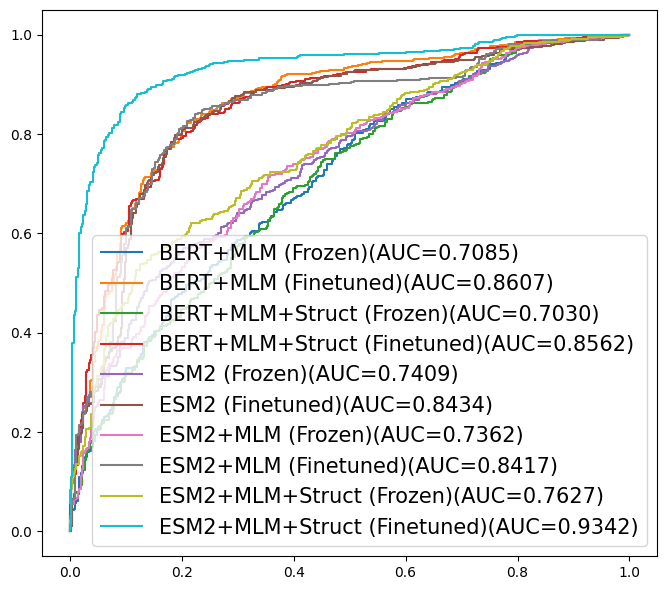

In [36]:
plt.figure(figsize=(7,6))
for key in fpr.keys():   
    plt.plot(fpr[key], tpr[key], label=f"{key}(AUC={auc[key]:.4f})")
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('roc_bind.png', dpi=600)

In [61]:
df_fpr = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in fpr.items()]))
df_fpr.to_csv("df_bind_fpr.csv", index=False)
df_tpr = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in tpr.items()]))
df_tpr.to_csv("df_bind_tpr.csv", index=False)